In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from sklearn.preprocessing import MinMaxScaler

c:\Users\peter\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\peter\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\peter\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
def normalize_dataframe(df):
    """
    Normalizes all columns in a pandas DataFrame  using MinMaxScaler.

    Args:
        df (pandas.DataFrame): The input DataFrame.

    Returns:
        pandas.DataFrame: The normalized DataFrame.
    """
    scaler = MinMaxScaler()
    columns_to_normalize = [col for col in df.columns]
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
    return df

In [3]:
def add_up_column(df):
    # Create empty 'up' and 'down' columns
    df['up'] = np.nan
    
    # Loop over the rows (skipping the first row)
    for i in range(0, len(df)-1):
        if df.loc[i+1, '4. close'] > df.loc[i, '4. close']:
            df.loc[i, 'up'] = 1
        else:
            df.loc[i, 'up'] = 0
    return df

In [4]:
def combine_csvs_from_folder(folder_path):
    """
    Combines all CSV files in a folder into a single pandas DataFrame also normalizes before combining them.

    Args:
        folder_path (str): The path to the folder containing the CSV files.

    Returns:
        A pandas DataFrame containing the concatenated data from all CSV files in the input folder.
    """
    # Use a list comprehension to read all CSV files in the folder into a list of DataFrames.
    dfs = [pd.read_csv(os.path.join(folder_path, f)) for f in os.listdir(folder_path) if f.endswith('.csv')]
    
    # Use a list comprehension to get the filenames of all CSV files in the folder.
    filenames = [os.path.splitext(os.path.basename(f))[0] for f in os.listdir(folder_path) if f.endswith('.csv')]

    processed_dfs = []
    i = 0
    for df, filename in zip(dfs, filenames):
        # Dont need the date column
        df = df.drop(['date'], axis=1)
        # normalize the dataframes before combining them
        df = normalize_dataframe(df)
        # for the neural network to understand the company name we need to convert it to a number
        df['company'] = i
        i += 1
        df = add_up_column(df)
        processed_dfs.append(df)
    combined_df = pd.concat(processed_dfs, ignore_index=True)
    
    return combined_df

df_full = combine_csvs_from_folder('market_data/merged_sentiment_data')

df_full.tail()

,Chaikin A/D,ADOSC,ADX,ADXR,APO,Aroon Down,Aroon Up,AROONOSC,ATR,Real Upper Band,...,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,sentiment,company,up
8579,1.000000,0.672490,0.258971,0.316359,0.754960,0.0,0.85,0.925,0.302798,0.951020,...,0.929540,0.951991,0.944602,0.965739,0.140781,0.0,0.0,0.766338,28,1.0
8580,0.998778,0.664732,0.266415,0.306323,0.732013,0.0,1.00,1.000,0.320301,0.943965,...,1.000000,1.000000,0.980350,1.000000,0.265542,0.0,0.0,0.764780,28,0.0
8581,0.966297,0.581039,0.254699,0.296031,0.687362,0.0,0.95,0.975,0.365638,0.918791,...,0.936562,0.941350,0.893466,0.916730,0.157345,0.0,0.0,0.755167,28,0.0
8582,0.931217,0.468669,0.246950,0.288036,0.623677,1.0,0.90,0.450,0.462123,0.939905,...,0.855206,0.814194,0.785275,0.813039,0.264651,0.0,0.0,0.502183,28,0.0
8583,0.901446,0.365450,0.247488,0.285341,0.568705,1.0,0.85,0.425,0.444907,0.964661,...,0.755206,0.776368,0.733902,0.763803,0.139751,0.0,0.0,0.415032,28,NaN


In [5]:
#we need this for later
def find_indices_of_test_rows(df):
    indices = []
    for i in range(1, len(df)):
        if np.isnan(df.loc[i, 'up']):
            indices.append(i)
    return indices
idxs = find_indices_of_test_rows(df_full)
print(idxs)


[295, 591, 887, 1183, 1479, 1775, 2071, 2367, 2663, 2959, 3255, 3551, 3847, 4143, 4439, 4735, 5031, 5327, 5623, 5919, 6215, 6511, 6807, 7103, 7399, 7695, 7991, 8287, 8583]


In [6]:
# we should one hot encode the company column
# first we need to change it to a string so we can one hot encode it
df_full['company'] = df_full['company'].astype(str)
df_full = pd.get_dummies(df_full, columns=['company'])

In [7]:
#drop nan rows
df_train = df_full.dropna()

In [8]:
# neural networks require tensors, so we need to convert our dataframes to tensors

def df_to_tensor(df):
    inputs_columns = df.columns[df.columns != 'up']
    inputs = torch.from_numpy(df.loc[:, inputs_columns].values.astype('float32'))
    targets = torch.from_numpy(df.loc[:, ['up']].values.astype('float32'))
    return inputs, targets


inputs, targets = df_to_tensor(df_train)
print(inputs[0])
print(inputs.shape)
print(targets.shape)

tensor([0.1353, 0.6197, 0.3955, 0.4593, 0.4225, 0.8500, 0.3500, 0.2500, 0.6032,
        0.8557, 0.9394, 0.9225, 0.3350, 0.3643, 0.2875, 0.7970, 0.5260, 0.9030,
        0.1048, 0.1016, 0.2951, 0.3613, 0.4410, 0.8099, 0.9726, 1.0000, 0.9390,
        0.3662, 0.4006, 0.3425, 0.4225, 0.5731, 0.2418, 0.6032, 0.0000, 0.1638,
        0.9062, 0.8188, 0.8024, 0.6250, 0.2994, 0.4558, 0.5325, 0.2254, 0.2272,
        0.4146, 0.2649, 0.2648, 0.2875, 0.8989, 0.9394, 0.7918, 0.6421, 0.7659,
        0.7918, 0.6817, 0.8398, 0.9730, 0.7253, 0.2869, 0.9107, 0.4255, 0.5867,
        0.4532, 0.8684, 0.7363, 0.7490, 0.7196, 0.7078, 0.7047, 0.3275, 0.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000])
torch.Size([8555, 103])
torch.Size([8555, 1])


In [9]:
dataset = TensorDataset(inputs, targets)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [10]:
# pytorch uses dataloaders to load data in batches

batch_size = 2**8
train_loader = DataLoader(train_dataset, batch_size, shuffle = True, num_workers = 0)
val_loader = DataLoader(val_dataset, batch_size, shuffle = False, num_workers = 0)

In [11]:
# use gpu if avaliable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
class NN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size), 
            nn.Sigmoid()
        )

        

    def forward(self, x):
        x = self.model(x)
        
        return x


# output size is 1 because we are predicting up=1 or down=0
input_size = inputs.shape[1]
output_size = 1
hidden_size = 2056
model = NN(input_size, output_size, hidden_size)
model.to(device)

NN(
  (model): Sequential(
    (0): Linear(in_features=103, out_features=2056, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2056, out_features=2056, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2056, out_features=2056, bias=True)
    (5): ReLU()
    (6): Linear(in_features=2056, out_features=2056, bias=True)
    (7): ReLU()
    (8): Linear(in_features=2056, out_features=2056, bias=True)
    (9): ReLU()
    (10): Linear(in_features=2056, out_features=1, bias=True)
    (11): Sigmoid()
  )
)

In [13]:
# hyperparameters for training
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 300

In [14]:
# training loop
training_losses = []
for epoch in range(1, num_epochs+1):
    epoch_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)
        # forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    #average the loss over all batches
    avg_loss = epoch_loss / len(train_loader)
    training_losses.append(avg_loss)
    if(epoch % 1000 == 0 or epoch == 1):
        print(f'epoch: {epoch}, avg_loss: {avg_loss}')

epoch: 1, avg_loss: 0.6997351381513808


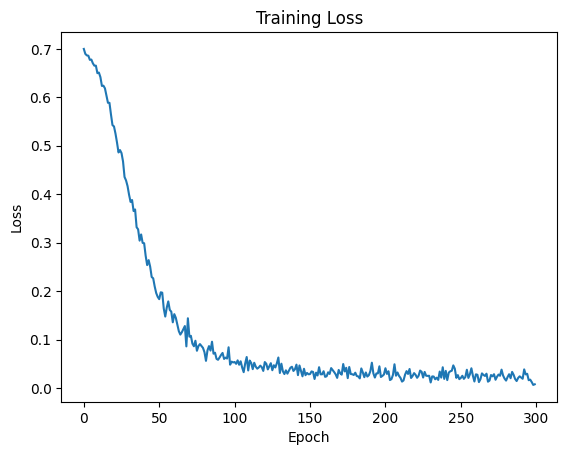

In [15]:
plt.plot(training_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [16]:
def validate(model, dataloader, criterion):
    model.eval() # Set the model to evaluation mode
    val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad(): # Disable gradient calculation for efficiency
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device) # Move data to GPU if available
            outputs = model(inputs)
            loss = criterion(outputs, targets.float()) # BCE loss expects float inputs
            val_loss += loss.item() * inputs.size(0) # Track total validation loss
            
            # Calculate accuracy
            predicted = torch.round(outputs)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    # Calculate average validation loss and accuracy
    val_loss /= len(dataloader.dataset)
    accuracy = correct / total
    
    return val_loss, accuracy

val_loss, val_acc = validate(model, val_loader, criterion)
print(f'val_loss: {val_loss}, val_acc: {val_acc}')

val_loss: 6.402916790936023, val_acc: 0.5604909409701929
